In [1]:
import wfdb 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats
import seaborn as sns
from collections import Counter
import librosa
import librosa.display

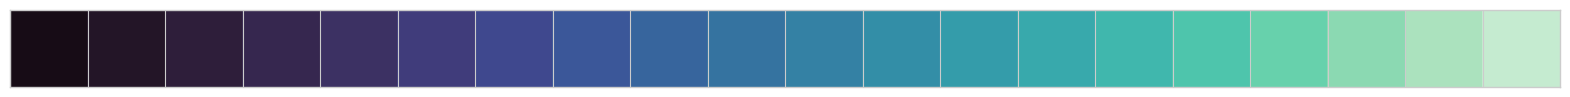

In [2]:
color_palette = sns.color_palette("mako", 20)
# plot settings
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette(color_palette)
# plot colours
sns.palplot(color_palette)

['Resp C', 'Resp A', 'Resp N', 'SpO2']


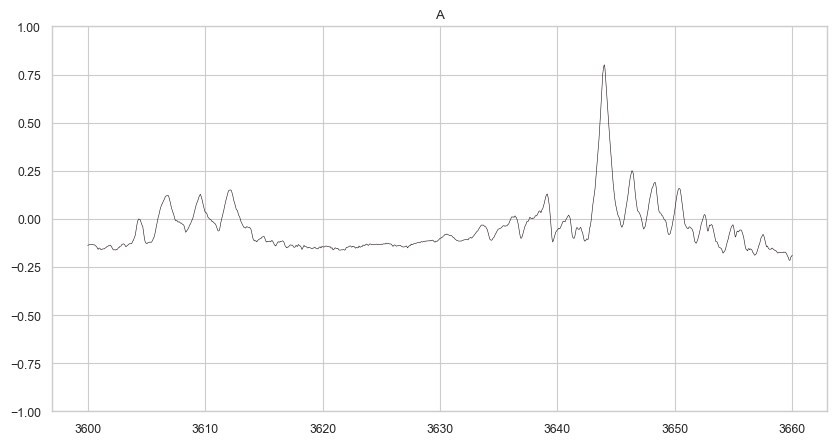

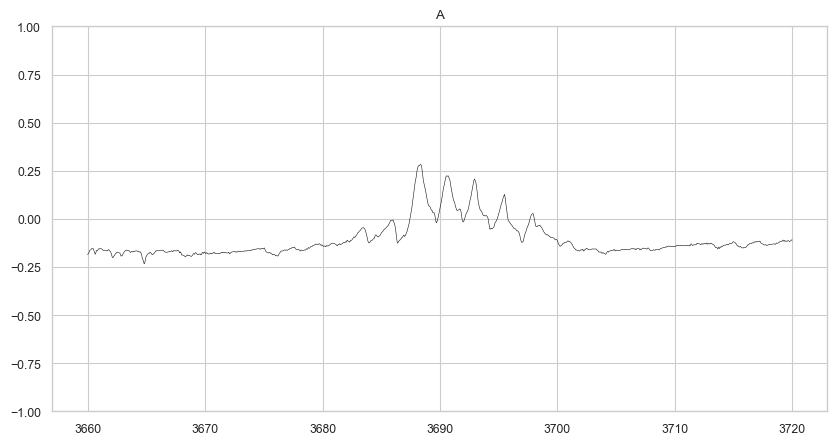

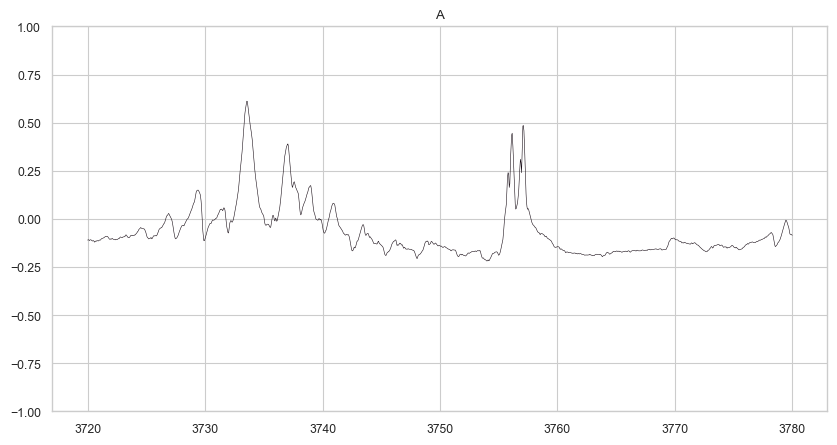

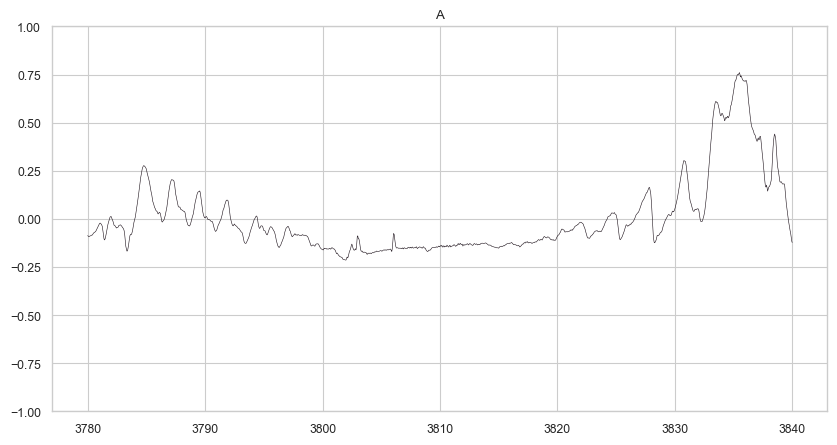

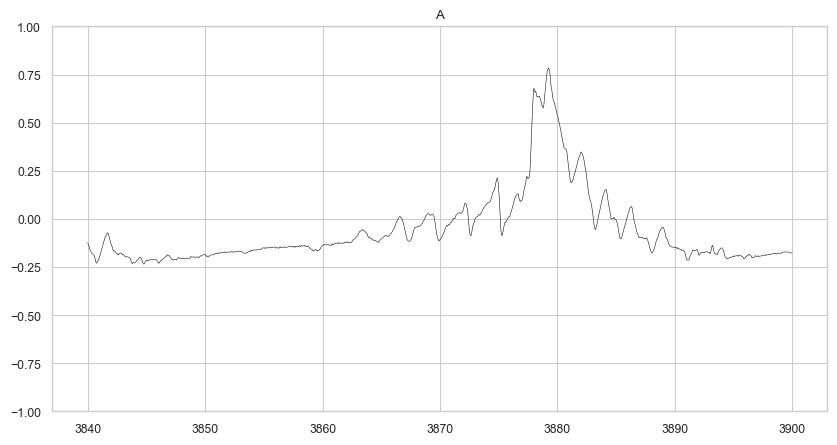

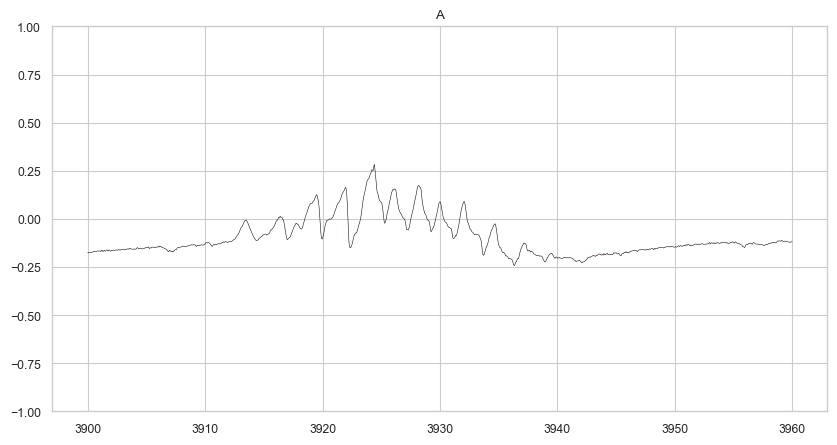

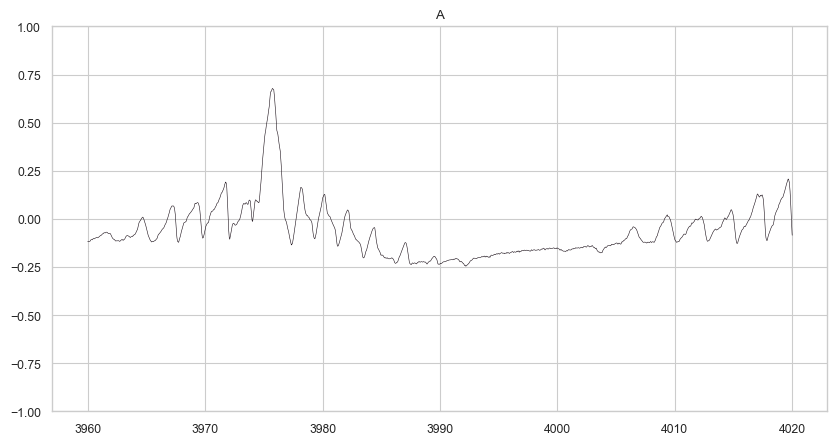

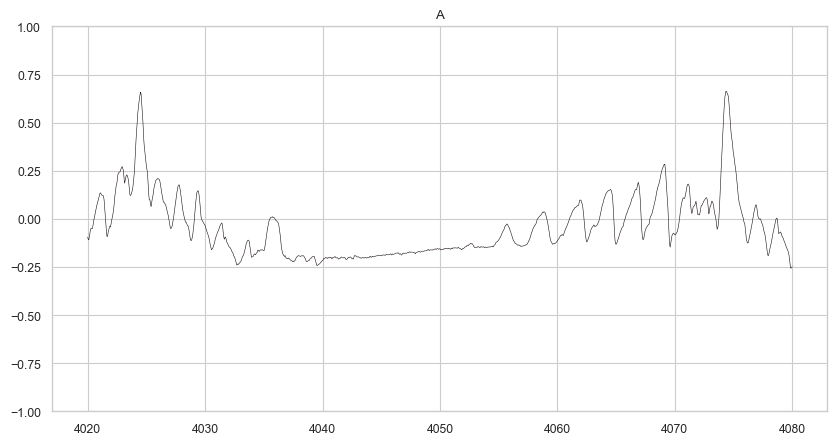

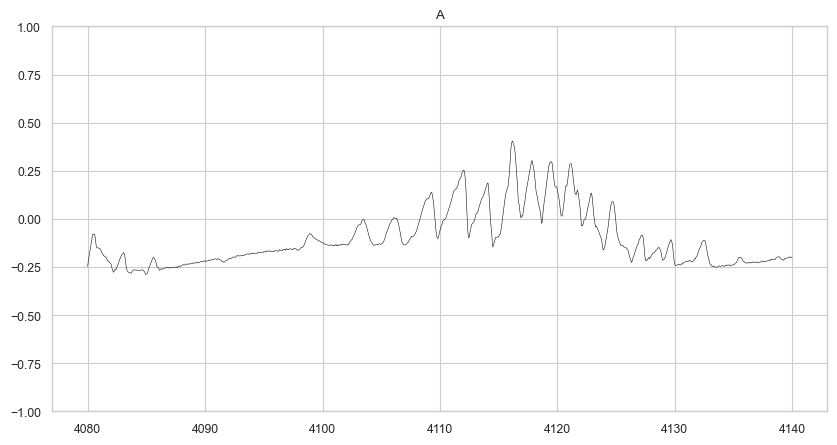

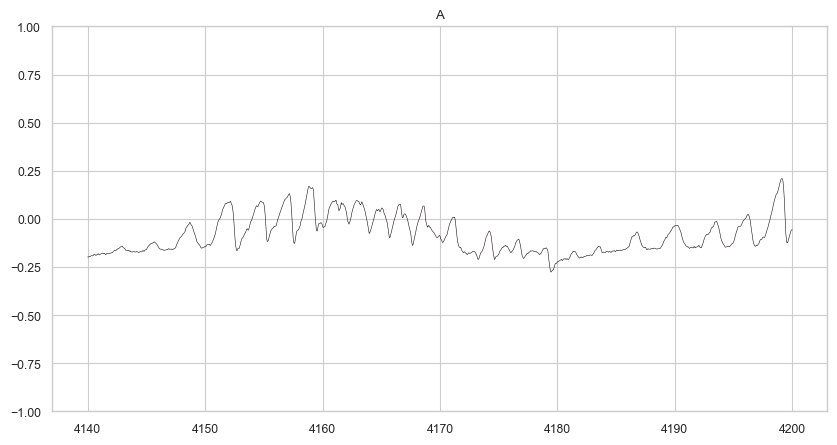

In [3]:

data_loc = "data/apnea_ecg/"
# create a function that takes a patient and returns the signal and the annotation
def get_patient(patient):
    record = wfdb.rdrecord(data_loc + patient)
    annotation = wfdb.rdann(data_loc + patient, 'apn')
    return record, annotation

# create a function that takes signal and annotation of patient and plots 10 intervals of the signal from specified index in annotation.sample, title of plot should be the annotation.symbol
def plot_intervals(patient, start_index, num_intervals=10, save=False):
    record, annotation = get_patient(patient)
    print(f"{record.sig_name}")
    for i in range(start_index, start_index + num_intervals):
        start = annotation.sample[i]
        end = annotation.sample[i+1]
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(start, end)/record.fs ,record.p_signal[start:end, 0], lw=0.4)
        plt.title(annotation.symbol[i])
        plt.ylim(-1, 1)
        if save:
            if not os.path.exists(f"plots/{patient}/"):
                os.makedirs(f"plots/{patient}/")
            plt.savefig(f"plots/{patient}/{patient}_index_sample_{annotation.sample[i]}_label_{annotation.symbol[i]}.png")
        plt.show()

# plot 10 intervals of patient a01r starting from index 0
# 'b01r', 'c01r', 'c02r', 'c03r'
plot_intervals("a02r", 60, save=False)


In [4]:
record.fs

NameError: name 'record' is not defined

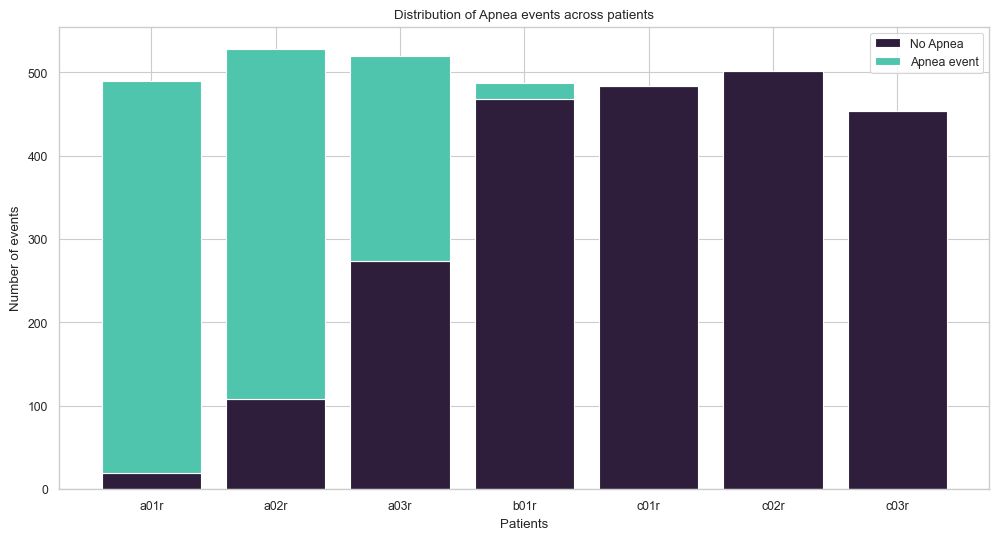

In [54]:
import seaborn as sns
patients = [ "a01r", "a02r", "a03r", "b01r", "c01r", "c02r", "c03r"]

# for each patient, get the distribution of the labels
def get_distribution(patients):
    distributions = []
    for patient in patients:
        record, annotation = get_patient(patient)
        distributions.append(Counter(annotation.symbol))
    return distributions

distributions = get_distribution(patients)

# plot the distribution of the labels for each patient
def plot_distribution(distributions):
    for i, distribution in enumerate(distributions):
        plt.figure(figsize=(10, 5))
        plt.bar(distribution.keys(), distribution.values())
        plt.title(f"Patient {patients[i]}")
        plt.show()

# get the distributions of the 2 labels across all patients
def get_label_distribution(distributions):
    label_distributions = []
    for distribution in distributions:
        label_distributions.append([distribution["N"], distribution["A"]])
    return label_distributions

label_distributions = get_label_distribution(distributions)

# plot the distribution of the labels across all patients

def plot_label_distribution(label_distributions):

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(label_distributions)), [x[0] for x in label_distributions], label="No Apnea", color=color_palette[2])
    plt.bar(np.arange(len(label_distributions)), [x[1] for x in label_distributions], bottom=[x[0] for x in label_distributions], label="Apnea event", color=color_palette[15])
    plt.xticks(np.arange(len(label_distributions)), patients)
    plt.title("Distribution of Apnea events across patients")
    plt.xlabel("Patients")
    plt.ylabel("Number of events")
    plt.legend()
    plt.show()

plot_label_distribution(label_distributions)


In [5]:
# use librosa to get stft of signal

# get record and annotation of patient
record, annotation = get_patient("a01r")

# get the signal

signal = record.p_signal[:, 0]

# segment signal into 60 second intervals according to anntoation.sample

def segment_signal(signal, annotation):
    segmented_signal = []
    for i in range(len(annotation.sample) - 1):
        start = annotation.sample[i]
        end = annotation.sample[i+1]
        segmented_signal.append(signal[start:end])
    return segmented_signal


segmented_signal = []
for i in range(len(annotation.sample) - 1):
    start = annotation.sample[i]
    end = annotation.sample[i+1]
    segmented_signal.append(signal[start:end])

indx = 2



def get_stft(signal, n_fft=512, hop_length=32):

    # get the stft of the signal
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

    # get the amplitude of the stft
    amplitude = np.abs(stft)

    # convert amplitude to decibels
    decibel = librosa.amplitude_to_db(amplitude)

    return decibel


# plot the stft of segment at index indx, as well as the original signal
def plot_stft(indx, n_fft=2048, hop_length=512, subplot_index=1):

    # get signal segment and label
    signal_segment = segmented_signal[indx]
    label = annotation.symbol[indx]

    # get the stft of the signal segment
    stft = get_stft(signal_segment, n_fft=n_fft, hop_length=hop_length)

    # plot the stft and original signal as subplots
    plt.subplot(2, 1, subplot_index)
    # keep color the same for all plots
    librosa.display.specshow(stft, sr=record.fs, hop_length=hop_length, x_axis="time", y_axis="hz")
    plt.colorbar()
    plt.title(f"STFT of {label} segment")

    plt.subplot(2, 1, subplot_index + 1)
    plt.plot(np.arange(len(signal_segment))/record.fs, signal_segment)
    plt.title(f"{label} segment")
    plt.ylim(-0.5, 0.5)

    plt.tight_layout()
    plt.show()

plot_stft(indx)

100


SyntaxError: 'return' outside function (2901818294.py, line 12)

In [ ]:
# get the stft of all segments

def get_stft_segments(segmented_signal, n_fft=2048, hop_length=512):
    stft_segments = []
    for signal_segment in segmented_signal:
        stft_segments.append(get_stft(signal_segment, n_fft=n_fft, hop_length=hop_length))
    return stft_segments




In [ ]:


# Define the window size and overlap
window_size = 4 * record.fs
overlap = 2 * record.fs
starting = 0
# Iterate over each interval
for i in range(num_intervals):
    start_index = (i+starting) * record.fs * 60
    end_index = (i +starting+1) * record.fs * 60
    
    # Extract the interval signal
    interval_signal = record.p_signal[start_index:end_index, 0]
    
    # Handle NaN values in the signal
    interval_signal = np.nan_to_num(interval_signal)
    
    # Compute the STFT spectrogram
    stft = librosa.stft(interval_signal, n_fft=window_size, hop_length=overlap)
    
    # Convert STFT to mel spectrogram
    mel_spec = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=record.fs)
    
    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Plot the mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spec_db, sr=record.fs, hop_length=overlap, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency')
    
    # Set the annotation as the title
    annotation_title = annotation.symbol[(i+starting)]
    plt.title(f'Mel Spectrogram - Interval {i+starting} ({annotation_title})')
    
    plt.show()


In [94]:
import os
import numpy as np
import wfdb
from scipy import signal
import librosa
import matplotlib.pyplot as plt

def create_spectrograms():
    # Create the "data/processed" directory if it doesn't exist
    processed_dir = "data/processed"
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    # Define the patients to load data from
    patients = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']

    # Create a dictionary to store the spectrograms
    spectrograms = {'STFT': {}, 'Mel': {}, 'LogMel': {}}

    # Iterate over the patients
    for patient in patients:
        # Load the record and annotation
        record = wfdb.rdrecord(f"data/apnea_ecg/{patient}")
        annotation = wfdb.rdann(f"data/apnea_ecg/{patient}", 'apn')

        # Iterate over the 60-second intervals
        interval_length = 60 * record.fs
        for i in range(len(record.p_signal) // interval_length):
            # Extract the interval signal
            start_index = i * interval_length
            end_index = (i + 1) * interval_length
            interval_signal = record.p_signal[start_index:end_index, 0]

            # Handle NaN values and Normalize the interval signal
            interval_signal = np.nan_to_num(interval_signal)
            interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)

            # Compute the STFT spectrogram
            _, _, Zxx = signal.stft(interval_signal, fs=record.fs)
            stft_spec = np.abs(Zxx)

            # Convert STFT to Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(S=stft_spec, sr=record.fs)

            # Convert Mel spectrogram to LogMel spectrogram
            logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Label for the current interval
            label = annotation.symbol[i] if i < len(annotation.symbol) else "Unknown"

            # Store the spectrograms
            for spec_type, spec_data in zip(['STFT', 'Mel', 'LogMel'], [stft_spec, mel_spec, logmel_spec]):
                if label not in spectrograms[spec_type]:
                    spectrograms[spec_type][label] = []
                spectrograms[spec_type][label].append(spec_data)

    # Save the spectrograms as image files
    for spec_type, labels in spectrograms.items():
        for label, spectrogram_list in labels.items():
            for i, spectrogram in enumerate(spectrogram_list):
                filename = f"{spec_type}_{label}_{i}.png"
                filepath = os.path.join(processed_dir, filename)
                plt.imsave(filepath, spectrogram)

    return "Spectrograms created and stored successfully."

# Call the function to create the spectrograms
create_spectrograms()


C:\Users\hamad\AppData\Local\Temp\ipykernel_40532\3073777779.py:36: RuntimeWarning: invalid value encountered in divide
  interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)
C:\Users\hamad\AppData\Local\Temp\ipykernel_40532\3073777779.py:36: RuntimeWarning: invalid value encountered in divide
  interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)


'Spectrograms created and stored successfully.'

In [95]:
import os
import shutil

def organize_spectrogram_images(source_dir, target_dir):
    """
    Organize spectrogram images into subfolders based on their type and label.
    
    Parameters:
    - source_dir: Directory containing the original spectrogram images.
    - target_dir: Directory where the organized images will be stored.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith('.png'):
            # Extract spectrogram type and label from the filename
            spec_type, label, _ = filename.split('_')

            # Create a subdirectory for the spectrogram type if it doesn't exist
            spec_type_dir = os.path.join(target_dir, spec_type)
            if not os.path.exists(spec_type_dir):
                os.makedirs(spec_type_dir)

            # Create a subdirectory for the label within the spectrogram type directory
            label_dir = os.path.join(spec_type_dir, label)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # Move the file to the appropriate subdirectory
            src_file = os.path.join(source_dir, filename)
            dest_file = os.path.join(label_dir, filename)
            shutil.move(src_file, dest_file)

    print("Spectrogram images organized successfully.")

# Example usage
source_directory = "data/processed"
target_directory = "data/organized_spectrograms"
organize_spectrogram_images(source_directory, target_directory)


Spectrogram images organized successfully.
